# ADA 2018 -  “Happiness” Share it through music.

#### Andres Montero, Ariel Alba, Diego Iriarte




In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os.path
import ast
import seaborn as sns

from helpers import *
from datetime import datetime, date, time
from scipy import stats

%load_ext autoreload
%autoreload 2


In [2]:
# Constants
DATA_DIR = './data/'
MUSIC_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                                  file='fma_metadata')
PKL_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                               file='pkl')

# True if we want to to execute the clean phase and to force 
# saving the cleaned file
CLEAN_PHASE = True
DEBUG = True


In [3]:
if CLEAN_PHASE:
    echonest_path = '{dir}{file}'.format(dir=MUSIC_DIR, 
                                         file='echonest.csv')
    features_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                         file='features.csv')
    genres_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='genres.csv')
    tracks_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='tracks.csv')
    

In [4]:
if CLEAN_PHASE:
    # Load datasets into pandas dataframes
    echonest_col_names=['track_id', 'danceability', 'energy',
                        'valence', 'artist_latitude',
                        'artist_longitude', 'artist_name',
                        'artist_discovery', 'artist_family',
                        'artist_hotness', 'song_currency', 
                        'song_hotness']
    
    echonest_dtypes = {'track_id': int, 'danceability': float, 
                       'energy': float, 'valence': float,
                       'artist_latitude': float, 'artist_longitude': float,
                       'artist_name': str, 'artist_discovery': float, 
                       'artist_family': float, 'artist_hotness': float,
                       'song_currency': float, 'song_hotness': float}
    
    echonest_df = pd.read_csv(echonest_path, names=echonest_col_names,
                              header=3, dtype=echonest_dtypes, 
                              usecols=[0, 2, 3, 8, 11, 13, 14,
                                       21, 22, 23, 24, 25])

    genres_dtypes = {'genre_id': int, '#tracks': int, 
                     'parent': int, 'top_level': int}
    
    genres_df = pd.read_csv(genres_path, dtype=genres_dtypes)
    
    track_col_names = ['track_id', 'album_date_created',
                       'album_date_released', 'album_id',
                       'album_listens', 'album_title', 
                       'artist_id', 'artist_latitude',
                       'artist_longitude', 'artist_name',
                       'track_duration', 'track_genre_top',
                       'track_genres_all', 'track_language', 
                       'track_listens', 'track_tags', 
                       'track_title']

    tracks_dtypes = {'track_id': int, 'album_date_created': str,
                     'album_date_released': str, 
                     'album_id': int, 'album_listens': int, 
                     'album_title': str, 'artist_id': int,
                     'artist_latitude': float, 'artist_longitude': float,
                     'artist_name': str, 'track_duration': int, 
                     'track_genre_top': str, 'track_genres_all': str, 
                     'track_language': str, 'track_listens': int,
                     'track_tags': str, 'track_title': str}

    tracks_df = pd.read_csv(tracks_path, names=track_col_names,
                            header=2, usecols=[0, 2, 3, 6, 8, 11,
                                               21, 22, 24, 26, 38, 
                                               40, 41, 45, 47, 51,
                                               52])


In [5]:
# Tracks clean phase
if CLEAN_PHASE:
    # Transforms str to datetime
    tracks_df['album_date_released'] = pd.to_datetime( \
                                            tracks_df['album_date_released'])
    tracks_df['album_date_created'] = pd.to_datetime( \
                                            tracks_df['album_date_created'])
    # Transform str to list
    tracks_df['track_tags'] = tracks_df['track_tags'] \
                                .apply(lambda x: ast.literal_eval(x))
    tracks_df['track_genres_all'] = tracks_df['track_genres_all'] \
                                .apply(lambda x: ast.literal_eval(x))


In [6]:
if CLEAN_PHASE:
    # Normalize dataframes to take out redundancy
    
    # Join echonist data to tracks
    echo_tracks = echonest_df.merge(tracks_df, left_on='track_id', 
                                    right_on='track_id', how='outer')
    
    print(len(echo_tracks))
     
    # Select main columns to create new df
    artists_df = echo_tracks[['artist_id', 'artist_name_x',
                              'artist_latitude_x', 'artist_longitude_x', 
                              'artist_discovery', 'artist_family', 
                              'artist_hotness', 'artist_latitude_y',
                              'artist_longitude_y', 'artist_name_y']].copy()

    albums_df = echo_tracks[['album_id', 'album_date_created',
                             'album_date_released', 'album_title',
                             'album_listens']].copy()
    
    tracks_df = echo_tracks[['track_id', 'track_title', 
                             'track_duration', 'artist_id', 
                             'album_id', 'track_genre_top',
                             'track_genres_all','track_language',
                             'track_listens', 'track_tags',
                             'danceability', 'energy',
                             'valence', 'song_currency',
                             'song_hotness']].copy()
    
    # Drop duplicates
    artists_df = artists_df.drop_duplicates('artist_id')
    albums_df = albums_df.drop_duplicates('album_id')
    
    # Reset Index
    artists_df = artists_df.reset_index(drop=True)
    albums_df = albums_df.reset_index(drop=True)
    
    # Clean listen count
    albums_df['album_listens'] = albums_df['album_listens'] \
                                    .apply(lambda x : neg_to_zero(x))
    
    tracks_df['track_listens'] = tracks_df['track_listens'] \
                                    .apply(lambda x : neg_to_zero(x))
    
    # Artist name different on echonest and FullMusicArchive
    if DEBUG:
        name_comp = not_eq_ign_case(artists_df['artist_name_x'],
                                    artists_df['artist_name_y'])
        artist_name_diff = artists_df[name_comp]
        
        print('# Different artist names: {}\n' \
                  .format(len(artist_name_diff)))

        print('Example:\n{}'.format(artist_name_diff[['artist_name_x',
                                                      'artist_name_y']].head(3)))


106574
# Different artist names: 13797

Example:
                        artist_name_x                    artist_name_y
2   Alec K. Redfearn and the Eyesores  Alec K. Redfearn & the Eyesores
26                      From Quagmire                        Dora Bleu
31                     Marc A. Pullen                          Fanatic


In [7]:
# Artist location different on echonest and FullMusicArchive
if DEBUG and CLEAN_PHASE:
    lat_comp = artists_df['artist_latitude_x'] != artists_df['artist_latitude_y']
    long_comp = artists_df['artist_longitude_x'] != artists_df['artist_longitude_y']
    latlong_comp = lat_comp | long_comp
    latlong_diff = artists_df[latlong_comp]

    print('# Different Lat Long values: {}\n' \
              .format(len(latlong_diff)))

    print('Example:\n{}'.format(artist_name_diff[['artist_latitude_x',
                                                  'artist_latitude_y',
                                                  'artist_longitude_x',
                                                  'artist_longitude_y']].head(3)))

# Different Lat Long values: 16339

Example:
    artist_latitude_x  artist_latitude_y  artist_longitude_x  \
2             41.8239          41.823989            -71.4120   
26                NaN                NaN                 NaN   
31            40.7978                NaN            -81.3716   

    artist_longitude_y  
2           -71.412834  
26                 NaN  
31                 NaN  


In [8]:
# Echonest clean phase 
if CLEAN_PHASE:
    # Get city, state, country from artist longitude and latitude
    cities=[]
    states=[]
    countries=[]
    
    for i in range (0, len(artists_df)):
        if np.isnan(artists_df.artist_latitude_y[i]):
            city = np.nan
            state = np.nan
            country = np.nan
        else:
            coordinates = (artists_df.artist_latitude_y[i], 
                           artists_df.artist_longitude_y[i])
            results = rg.search(coordinates, mode=1)
            city = results[0]['name']
            state = results[0]['admin1']
            country = results[0]['cc']
        
        cities.append(city)
        states.append(state)
        countries.append(country)
    
    artists_df.insert(loc=5, column='city', 
                      value=pd.Series(cities))
    artists_df.insert(loc=6, column='state',
                      value=pd.Series(states))
    artists_df.insert(loc=7, column='country', 
                      value=pd.Series(countries))
    

Loading formatted geocoded file...


In [9]:
# Read  and wirte files depending on the existance of own path
echonest_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                        file='echonest_df.pkl')
genres_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='genres_df.pkl')
albums_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='albums_df.pkl')
artists_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='artists_df.pkl')
tracks_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                      file='tracks_df.pkl')

if CLEAN_PHASE:
    genres_df.to_pickle(genres_df_path)
elif os.path.exists(echonest_df_path):
    genres_df = pd.read_pickle(genres_df_path)
else:
    print('There is no genres pandas data')
    
if CLEAN_PHASE:
    albums_df.to_pickle(albums_df_path)
elif os.path.exists(albums_df_path):
    albums_df = pd.read_pickle(albums_df_path)
else:
    print('There is no albums pandas data')
    
if CLEAN_PHASE:
    artists_df.to_pickle(artists_df_path)
elif os.path.exists(artists_df_path):
    artists_df = pd.read_pickle(artists_df_path)
else:
    print('There is no albums pandas data')
    
if CLEAN_PHASE:
    tracks_df.to_pickle(tracks_df_path)
elif os.path.exists(tracks_df_path):
    tracks_df = pd.read_pickle(tracks_df_path)
else:
    print('There is no albums tracks data')
    

In [10]:
print('Artists size: {}'.format(len(artists_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(artists_df.isna().sum(axis=0)))
artists_df.head()


Artists size: 16341

NaN count by column:
artist_id                 0
artist_name_x         13465
artist_latitude_x     14338
artist_longitude_x    14338
artist_discovery      13465
city                  12505
state                 12505
country               12505
artist_family         13465
artist_hotness        13465
artist_latitude_y     12505
artist_longitude_y    12505
artist_name_y             0
dtype: int64


,artist_id,artist_name_x,artist_latitude_x,artist_longitude_x,artist_discovery,city,state,country,artist_family,artist_hotness,artist_latitude_y,artist_longitude_y,artist_name_y
0,1,AWOL,32.6783,-83.2230,0.388990,Lakehurst,New Jersey,US,0.386740,0.406370,40.058324,-74.405661,AWOL
1,6,Kurt Vile,39.9523,-75.1624,0.557339,NaN,NaN,NaN,0.614272,0.798387,NaN,NaN,Kurt Vile
2,54,Alec K. Redfearn and the Eyesores,41.8239,-71.4120,0.388923,Providence,Rhode Island,US,0.330784,0.406300,41.823989,-71.412834,Alec K. Redfearn & the Eyesores
3,56,Amoebic Ensemble,41.8239,-71.4120,0.252381,Providence,Rhode Island,US,0.238153,0.263657,41.823989,-71.412834,Amoebic Ensemble
4,60,Arc and Sender,NaN,NaN,0.262717,Philadelphia,Pennsylvania,US,0.173315,0.274455,39.952335,-75.163789,Arc and Sender


In [11]:
print('Albums size: {}'.format(len(albums_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(albums_df.isna().sum(axis=0)))
albums_df.head()


Albums size: 14854

NaN count by column:
album_id                  0
album_date_created      459
album_date_released    5404
album_title               1
album_listens             0
dtype: int64


,album_id,album_date_created,album_date_released,album_title,album_listens
0,1,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
1,6,2008-11-26 01:45:08,2008-02-06,Constant Hitmaker,47632.0
2,60,2008-11-26 01:49:57,2009-01-16,Every Man For Himself,1304.0
3,61,2008-11-26 01:49:59,2007-05-22,The Blind Spot,1300.0
4,62,2008-11-26 01:50:03,2005-01-25,The Quiet Room,845.0


In [12]:
print('Echonest size: {}'.format(len(echonest_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(echonest_df.isna().sum(axis=0)))
echonest_df.head()


Echonest size: 13129

NaN count by column:
track_id               0
danceability           0
energy                 0
valence                0
artist_latitude     3359
artist_longitude    3359
artist_name            0
artist_discovery       0
artist_family          0
artist_hotness         0
song_currency          0
song_hotness           0
dtype: int64


,track_id,danceability,energy,valence,artist_latitude,artist_longitude,artist_name,artist_discovery,artist_family,artist_hotness,song_currency,song_hotness
0,2,0.675894,0.634476,0.576661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
1,3,0.528643,0.817461,0.269240,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
2,5,0.745566,0.701470,0.621661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
3,10,0.658179,0.924525,0.963590,39.9523,-75.1624,Kurt Vile,0.557339,0.614272,0.798387,0.005158,0.354516
4,134,0.513238,0.560410,0.894072,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000


In [13]:
print('Genres size: {}'.format(len(genres_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(genres_df.isna().sum(axis=0)))
genres_df.head()


Genres size: 163

NaN count by column:
genre_id     0
#tracks      0
parent       0
title        0
top_level    0
dtype: int64


,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [14]:
print('Tracks size: {}'.format(len(tracks_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(tracks_df.isna().sum(axis=0)))
tracks_df.head()


Tracks size: 106574

NaN count by column:
track_id                0
track_title             1
track_duration          0
artist_id               0
album_id                0
track_genre_top     56976
track_genres_all        0
track_language      91550
track_listens           0
track_tags              0
danceability        93445
energy              93445
valence             93445
song_currency       93445
song_hotness        93445
dtype: int64


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness
0,2,Food,168,1,1,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000
1,3,Electric Ave,237,1,1,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000
2,5,This World,206,1,1,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000
3,10,Freeway,161,6,6,Pop,[10],en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516
4,134,Street Music,207,1,1,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000


#### First we will see the top 10 countries were the music is produced.

In [15]:
#Merge data to have the entire data frame
tracks_echonest = echonest_df.merge(tracks_df, left_on='track_id', 
                                    right_on='track_id', how='right')
tracks_echonest.head()


,track_id,danceability_x,energy_x,valence_x,artist_latitude,artist_longitude,artist_name,artist_discovery,artist_family,artist_hotness,...,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability_y,energy_y,valence_y,song_currency_y,song_hotness_y
0,2,0.675894,0.634476,0.576661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000
1,3,0.528643,0.817461,0.269240,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000
2,5,0.745566,0.701470,0.621661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000
3,10,0.658179,0.924525,0.963590,39.9523,-75.1624,Kurt Vile,0.557339,0.614272,0.798387,...,Pop,[10],en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516
4,134,0.513238,0.560410,0.894072,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000


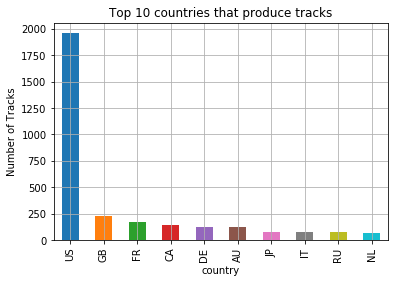

In [16]:
track_artist = tracks_df.merge(artists_df, left_on='artist_id', 
                               right_on='artist_id')
country_grouped = track_artist.groupby(track_artist['country']).size()
country_top10 = country_grouped.sort_values(ascending=False) \
                                     .head(10)
country_top10.plot(kind='bar', 
                   title="Top 10 countries that produce tracks")
plt.ylabel('Number of Tracks')
plt.grid()


#### Top 10 albums

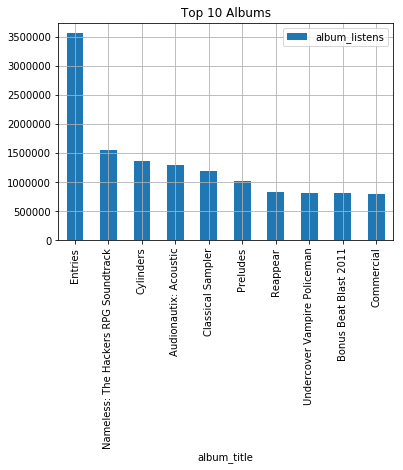

In [17]:
albums_grouped = albums_df.groupby(albums_df['album_id']) \
                          .first()[['album_title', 'album_listens']]
albums_top10 = albums_grouped.sort_values(by='album_listens', 
                                          ascending=False).head(10)
albums_top10.plot(x='album_title', kind='bar', title="Top 10 Albums")
plt.grid()


#### Top 10 Tracks

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

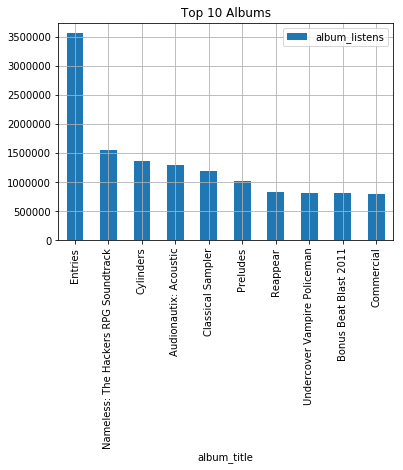

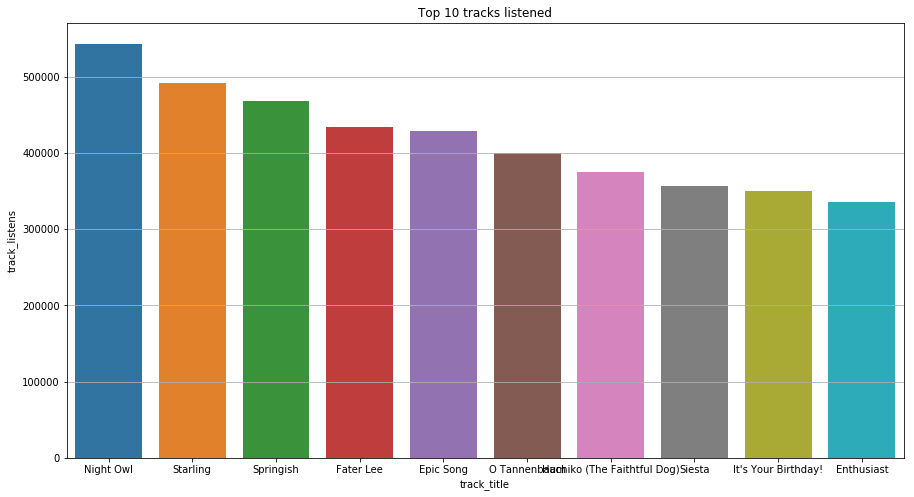

In [34]:
tracks_grouped = tracks_df.groupby(tracks_df['track_id']) \
                          .first()[['track_title', 'track_listens']]
tracks_top10 = tracks_grouped.sort_values(by='track_listens', 
                                          ascending=False).head(10)

albums_top10.plot(x='album_title', kind='bar', title="Top 10 Albums")
plt.grid()
plt.figure(figsize=(15, 8))
plt.title("Top 10 tracks listened")
plt.grid()
ax = sns.barplot(x='track_title', y= 'track_listens',
                 data=tracks_top10)
ax.set_xticklabels(rotation=30)


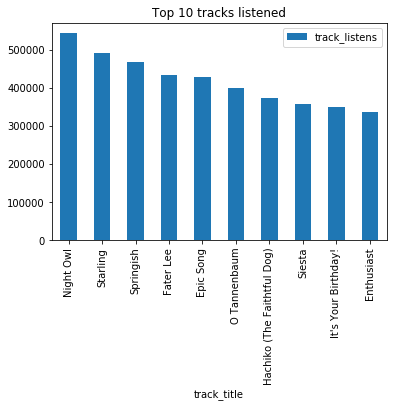

In [27]:

# albums_top10.plot(x='album_title', kind='bar', title="Top 10 Albums")
# plt.grid()
# plt.figure(figsize=(15, 8))
# plt.title("Top 10 tracks listened")
# plt.grid()
# ax = sns.barplot(x='track_title', y= 'track_listens',
#                  data=tracks_top10)
tracks_top10.plot(x='track_title', kind='bar', title='Top 10 tracks listened')

#### Relation between danceability and duration of the song

In [19]:
tracks_df.insert(loc=15, column='track_duration_minutes',
                 value=(tracks_df['track_duration'] / 60))

tracks_df['track_duration_minutes'] = pd.to_numeric(tracks_df['track_duration_minutes'])


C:\Users\Andres Montero\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


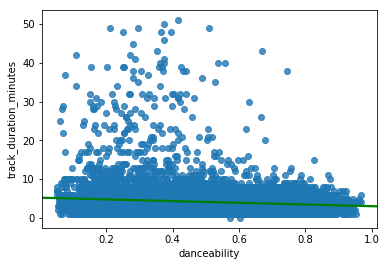

In [20]:
# intervals = pd.IntervalIndex.from_arrays([0, 2, 4], 
#                                          [2, 4, 1000], closed='left')

# tracks_df['duration_class'] = pd.cut(tracks_df['track_duration_minutes'], 
#                                      bins=intervals)

tracks_df['track_duration_minutes'] = tracks_df['track_duration_minutes'] \
                                                .apply(lambda x : np.rint(x))
sns.regplot(x='danceability', y='track_duration_minutes',
            data=tracks_df, ci=95, 
            line_kws = {'color': 'green'})


In [21]:
tracks_df.head()


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness,track_duration_minutes
0,2,Food,168,1,1,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000,3.0
1,3,Electric Ave,237,1,1,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000,4.0
2,5,This World,206,1,1,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000,3.0
3,10,Freeway,161,6,6,Pop,[10],en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516,3.0
4,134,Street Music,207,1,1,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000,3.0


In [22]:
spearman_coeff = stats.spearmanr(tracks_df['danceability'], 
                                 tracks_df['track_duration_minutes'])
spearman_coeff


SpearmanrResult(correlation=nan, pvalue=nan)

In [23]:
track_album = tracks_df.merge(albums_df, left_on='album_id',
                              right_on='album_id')

genre_year = track_album[['track_genre_top', 'album_date_released']]
genre_year.insert(loc=2, column='album_released_year',
                  value=(genre_year['album_date_released'].dt.year))
genre_year.head()


,track_genre_top,album_date_released,album_released_year
0,Hip-Hop,2009-01-05,2009.0
1,Hip-Hop,2009-01-05,2009.0
2,Hip-Hop,2009-01-05,2009.0
3,Hip-Hop,2009-01-05,2009.0
4,Hip-Hop,2009-01-05,2009.0


In [24]:
top_genre = genre_year.groupby(genre_year['track_genre_top']).size()

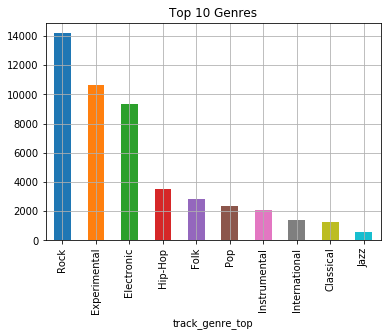

In [25]:
top_genre_sorted = top_genre.sort_values(ascending=False).head(10)
top_genre_sorted.plot(kind='bar', title="Top 10 Genres")
plt.grid()
